# 개와 고양이 분류 (CNN 모델 직접 구축)

이 노트북은 전이 학습(Transfer Learning)을 사용하지 않고, 처음부터 직접 합성곱 신경망(CNN)을 구축하여 개와 고양이 이미지를 분류합니다. 

**프로세스:**
1. **데이터 준비**: Kaggle의 "Dogs vs. Cats" 데이터셋을 다운로드하고, 손상된 파일을 제거한 후, 훈련(train), 검증(validation), 테스트(test)용으로 데이터를 분할합니다.
2. **데이터 로딩**: `image_dataset_from_directory`를 사용하여 디렉토리에서 이미지를 효율적으로 로드합니다.
3. **모델 구축**: 데이터 증강(Data Augmentation)을 포함한 간단한 CNN 모델을 정의합니다.
4. **학습 및 평가**: 모델을 학습시키고, 학습 과정을 시각화한 후, 테스트 데이터셋으로 최종 성능을 평가합니다.

## 1. 라이브러리 임포트

In [1]:
import os
import shutil
import pathlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, optimizers
import matplotlib.pyplot as plt

## 2. 데이터 준비

### 2.1. 데이터셋 다운로드 및 손상된 파일 제거

In [2]:
dataset_url = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'
zip_path = tf.keras.utils.get_file('kagglecatsanddogs.zip', origin=dataset_url, extract=True)
original_dir = pathlib.Path(zip_path).parent / 'PetImages'

# 손상된 이미지 제거
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = original_dir / folder_name
    if not folder_path.is_dir(): continue
    for fname in os.listdir(folder_path):
        fpath = folder_path / fname
        if not fpath.is_file(): continue
        try:
            with open(fpath, "rb") as fobj:
                is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        except Exception:
            is_jfif = False
        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)
print(f"손상된 이미지 {num_skipped}개를 삭제했습니다.")

824887076/824887076 [==============================] - 12s 0us/step
손상된 이미지 1578개를 삭제했습니다.


### 2.2. 훈련/검증/테스트용 서브셋 생성

In [3]:
new_base_dir = pathlib.Path("./cats_vs_dogs_small_scratch")
if not new_base_dir.exists():
    print("훈련, 검증, 테스트 서브셋을 새로 생성합니다...")
    for subset_name, start, end in [("train", 0, 1000), ("validation", 1000, 1500), ("test", 1500, 2000)]:
        for category in ("Cat", "Dog"):
            dir = new_base_dir / subset_name / category
            os.makedirs(dir, exist_ok=True)
            fnames = sorted(os.listdir(original_dir / category))[start:end]
            for fname in fnames:
                shutil.copyfile(src=original_dir / category / fname, dst=dir / fname)
else:
    print("서브셋 디렉토리가 이미 존재하여 재생성하지 않습니다.")

훈련, 검증, 테스트 서브셋을 새로 생성합니다...


## 3. 데이터 로더 생성

In [4]:
from keras.utils import image_dataset_from_directory

BATCH_SIZE = 32
IMAGE_SIZE = (180, 180)

train_ds = image_dataset_from_directory(new_base_dir / "train", image_size=IMAGE_SIZE, batch_size=BATCH_SIZE)
validation_ds = image_dataset_from_directory(new_base_dir / "validation", image_size=IMAGE_SIZE, batch_size=BATCH_SIZE)
test_ds = image_dataset_from_directory(new_base_dir / "test", image_size=IMAGE_SIZE, batch_size=BATCH_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


## 4. CNN 모델 정의 및 컴파일

In [5]:
# 데이터 증강 레이어
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# 모델 구성
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

x = layers.Conv2D(32, (3,3), activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Conv2D(64, (3,3), activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Conv2D(128, (3,3), activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)

# 모델 컴파일
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                          

## 5. 모델 학습

In [7]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

history = model.fit(
    train_ds,
    epochs=2, # 에포크 수를 늘려 충분히 학습 50
    validation_data=validation_ds,
    callbacks=callbacks
)

Epoch 1/2
63/63 [==============================] - 42s 666ms/step - loss: 0.6799 - accuracy: 0.5795 - val_loss: 0.6746 - val_accuracy: 0.5880
Epoch 2/2
63/63 [==============================] - 43s 677ms/step - loss: 0.6705 - accuracy: 0.5860 - val_loss: 0.6543 - val_accuracy: 0.6180


## 6. 학습 결과 시각화

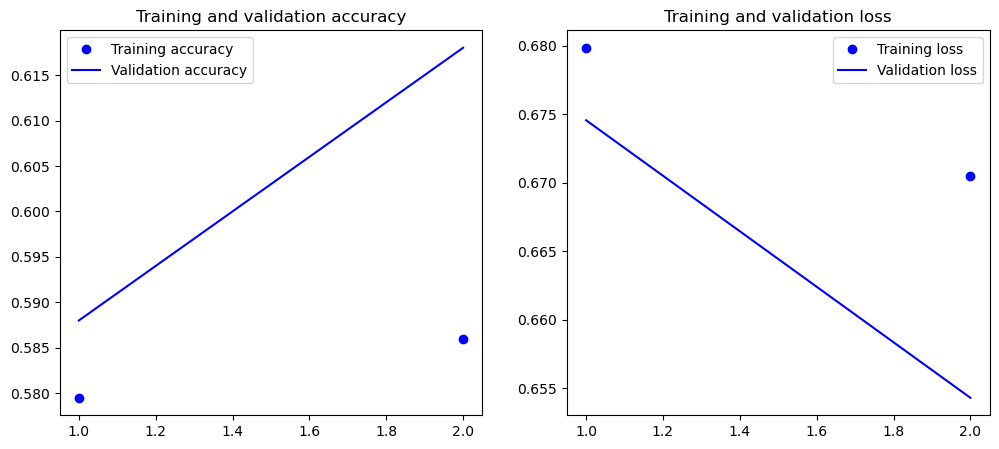

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 7. 최종 모델 평가

In [9]:
best_model = keras.models.load_model("convnet_from_scratch.keras")

print("테스트 데이터셋으로 최종 모델을 평가합니다...")
test_loss, test_acc = best_model.evaluate(test_ds)
print(f'최종 테스트 정확도: {test_acc*100:.2f}%')

테스트 데이터셋으로 최종 모델을 평가합니다...
32/32 [==============================] - 4s 110ms/step - loss: 0.6635 - accuracy: 0.5900
최종 테스트 정확도: 59.00%
